<a href="https://colab.research.google.com/github/sanjeesi/Data-Science/blob/master/Data%20Science%20IITM/MLP/Week9/02%20Decision_Trees_for_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees for Regression
Decision trees are capable of finding complex nonlinear relationships in the data. They can perform both classification and regression tasks. In this notebook, we will demonstrate decision trees for regression task with California housing dataset and `DecisionTreeRegressor` class in `sklearn`.

## Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

In [ ]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits and 20% examples set aside as test examples.

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

## Load the data set

In [ ]:
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(
    features, labels, random_state=42)

# train --> test + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42)

## Model setup

In [ ]:
dt_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                            ("dt_reg", DecisionTreeRegressor(max_depth=3, random_state=42))])
dt_reg_cv_results = cross_validate(dt_reg_pipeline,
                                   com_train_features,
                                   com_train_labels,
                                   cv=cv,
                                   scoring="neg_mean_absolute_error",
                                   return_train_score=True,
                                   return_estimator=True)
dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
0.590 +/- 0.005
Mean absolute error of linear regression model on the test set:
0.593 +/- 0.007


## Visualizing the tree
One of the advantages of using a decision tree algorithm is that the output is intuitive to understand and can be easily visualised.  
This can be done in two ways:
- As a tree diagram
- As a text based diagram

### 1. As a tree diagram
We need to call `fit` function on `pipeline` object before printing the tree.

In [ ]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

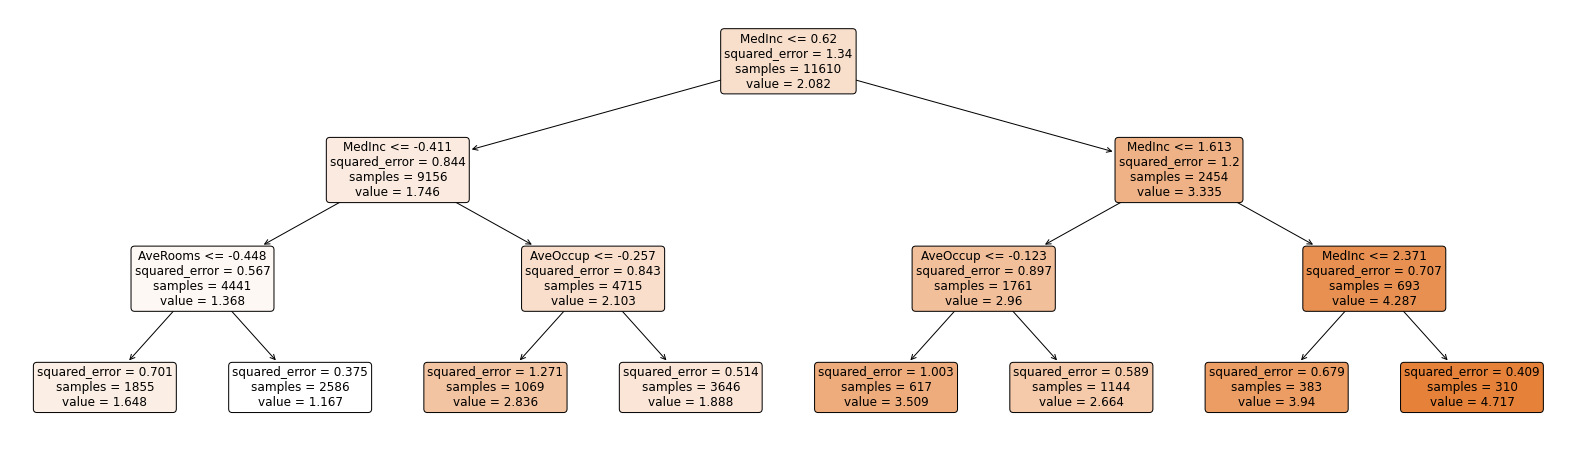

In [ ]:
plt.figure(figsize=(28, 8), facecolor='w')
# create the tree plot
a = tree.plot_tree(dt_reg_pipeline[-1],
                   # use the feature names stored
                   feature_names = features.columns,
                   rounded=True,
                   filled=True,
                   fontsize=12)
# show the plot
plt.show()

### 2. As a test-based diagram

In [ ]:
# export the decision rules
tree_rules = export_text(dt_reg_pipeline[-1])
# print the result
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



## Using the tree for prediction

In [ ]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

## Evaluating the tree

In [ ]:
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print("The model performance for testing set")
print("---------------------------------------")
print('MAE is ', mae)
print('MSE is ', mse)
print('R2 score is ', r2)

The model performance for testing set
---------------------------------------
MAE is  0.6005762942842664
MSE is  0.6417557936098145
R2 score is  0.5150037690483743


Let us now try to improve the model by tuning the hyperparameters

In [ ]:
param_grid = {'dt_reg__max_depth': range(1, 20),
              'dt_reg__min_samples_split': range(2,8)}
dt_grid_search = GridSearchCV(dt_reg_pipeline,
                              param_grid=param_grid,
                              n_jobs=2,
                              cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True)
dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
mean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

print(f"Best Mean absolute error of linear regression model on the train set:\n"
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of linear regression model on the train set:
0.278 +/- 0.006
Mean absolute error of linear regression model on the test set:
0.428 +/- 0.012


In [ ]:
print("Mean cross validate score of the best estimator is: ", -1*dt_grid_search.best_score_)

Mean cross validate score of the best estimator is:  0.4283313044233501


In [ ]:
print("The best parameter value is:", dt_grid_search.best_params_)

The best parameter value is: {'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}


Let's retrain the model with the best hyperparameter values.

In [ ]:
dt_reg_pipeline.set_params(
    dt_reg__max_depth=11, dt_reg__min_samples_split=5
).fit(com_train_features, com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [ ]:
test_labels_pred = dt_reg_pipeline.predict(test_features)
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print("The model performance for testing set")
print("---------------------------------------")
print('MAE is ', mae)
print('MSE is ', mse)
print('R2 score is ', r2)

The model performance for testing set
---------------------------------------
MAE is  0.4248952183820017
MSE is  0.4154957726373763
R2 score is  0.6859960039130073
